# Estimating Gestational Diabetes Onset
### Reverse Timeseries Forecasting

## Pre-processing: Full Dataset

<ul>
	<li><a href="#Imports"><strong>Imports</strong></a></li>
	<li><a href="#Notebook-Settings"><strong>Notebook Settings</a></li>
	<li><a href="#Load-the-data"><strong>Loading the data</strong></a>
		<ul>
			<li>Setting the index</li>
			<li>Reverse the timeseries</li>
		</ul>
	</li>
    <li><a href="#Visualize"><strong>Visualize</strong></a>
		<ul>
			<li>Seasonal Decompose</li>
		</ul>
	</li>
    <li><a href="#Stationarity"><strong>Stationarity</strong></a>
		<ul>
			<li>Dickey Fuller Test</li>
			<li>KPSS</li>
		</ul>
	</li>
    <li><a href="#ACF-and-PACF"><strong>ACF and PACF</strong></a></li>
    <li><a href="#Save-Stationary-Data"><strong>Saving te Data</strong></a></li>
</ul>


### Imports

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from library.sb_utils import save_file
from library.functions import jlcap_test_stationarity
from library.functions import jlcap_optimize_arima

### Notebook Settings

In [45]:
pd.set_option('display.max_rows', 500)

### Load the data

In [46]:
df = pd.read_csv('data/data_cleaned.csv')

In [47]:
df.datetime = pd.to_datetime(df.datetime)

df.set_index('datetime')

,type,value,unit,month,date,daycount,subtype,outOfRange
datetime,,,,,,,,
2021-03-11 07:11:00,Blood Sugar Reading,104,mg/dL,3,2021-03-11,1,fasting,True
2021-03-11 08:01:00,Carbs,26,g,3,2021-03-11,1,breakfast,False
2021-03-11 09:20:00,Blood Sugar Reading,121,mg/dL,3,2021-03-11,1,after_breakfast,False
2021-03-11 11:18:00,Carbs,27,g,3,2021-03-11,1,snack_morning,False
2021-03-11 13:30:00,Carbs,30,g,3,2021-03-11,1,lunch,False
...,...,...,...,...,...,...,...,...
2021-05-23 12:45:00,Carbs,23,g,5,2021-05-23,74,snack_morning,False
2021-05-23 15:16:00,Carbs,34,g,5,2021-05-23,74,lunch,False
2021-05-23 20:16:00,Carbs,23,g,5,2021-05-23,74,dinner,False


**REVERSE**

In [48]:
df_reverse = df.iloc[::-1]

In [49]:
df_reverse.set_index('datetime', inplace=True)
df_reverse.head()

,type,value,unit,month,date,daycount,subtype,outOfRange
datetime,,,,,,,,
2021-05-23 21:56:00,Carbs,14,g,5,2021-05-23,74,snack_night,False
2021-05-23 21:17:00,Blood Sugar Reading,105,mg/dL,5,2021-05-23,74,after_dinner,False
2021-05-23 20:16:00,Carbs,23,g,5,2021-05-23,74,dinner,False
2021-05-23 15:16:00,Carbs,34,g,5,2021-05-23,74,lunch,False
2021-05-23 12:45:00,Carbs,23,g,5,2021-05-23,74,snack_morning,False


**Save original date column and then set it as the index in the reversed dataframe**

We need the target vairable to be positively monotonic or the ARIMA model will fail.

In [52]:
date_forward = df.datetime
date_forward

0     2021-03-11 07:11:00
1     2021-03-11 08:01:00
2     2021-03-11 09:20:00
3     2021-03-11 11:18:00
4     2021-03-11 13:30:00
              ...        
688   2021-05-23 12:45:00
689   2021-05-23 15:16:00
690   2021-05-23 20:16:00
691   2021-05-23 21:17:00
692   2021-05-23 21:56:00
Name: datetime, Length: 693, dtype: datetime64[ns]

In [53]:
df_reverse.reset_index(inplace=True)

In [54]:
df_reverse = df_reverse.join(date_forward, on=df_reverse.index, how='left', rsuffix='_forward')


In [55]:
df_reverse.dtypes

datetime            datetime64[ns]
type                        object
value                        int64
unit                        object
month                        int64
date                        object
daycount                     int64
subtype                     object
outOfRange                    bool
datetime_forward    datetime64[ns]
dtype: object

In [56]:
df_reverse = df_reverse.set_index('datetime_forward')

In [57]:
df_reverse

,datetime,type,value,unit,month,date,daycount,subtype,outOfRange
datetime_forward,,,,,,,,,
2021-03-11 07:11:00,2021-05-23 21:56:00,Carbs,14,g,5,2021-05-23,74,snack_night,False
2021-03-11 08:01:00,2021-05-23 21:17:00,Blood Sugar Reading,105,mg/dL,5,2021-05-23,74,after_dinner,False
2021-03-11 09:20:00,2021-05-23 20:16:00,Carbs,23,g,5,2021-05-23,74,dinner,False
2021-03-11 11:18:00,2021-05-23 15:16:00,Carbs,34,g,5,2021-05-23,74,lunch,False
2021-03-11 13:30:00,2021-05-23 12:45:00,Carbs,23,g,5,2021-05-23,74,snack_morning,False
...,...,...,...,...,...,...,...,...,...
2021-05-23 12:45:00,2021-03-11 13:30:00,Carbs,30,g,3,2021-03-11,1,lunch,False
2021-05-23 15:16:00,2021-03-11 11:18:00,Carbs,27,g,3,2021-03-11,1,snack_morning,False
2021-05-23 20:16:00,2021-03-11 09:20:00,Blood Sugar Reading,121,mg/dL,3,2021-03-11,1,after_breakfast,False


In [59]:
df_reverse.index = pd.DatetimeIndex(df_reverse.index)
df_reverse.index

DatetimeIndex(['2021-03-11 07:11:00', '2021-03-11 08:01:00',
               '2021-03-11 09:20:00', '2021-03-11 11:18:00',
               '2021-03-11 13:30:00', '2021-03-11 14:35:00',
               '2021-03-11 17:30:00', '2021-03-11 18:55:00',
               '2021-03-11 19:54:00', '2021-03-12 07:04:00',
               ...
               '2021-05-22 17:21:00', '2021-05-22 21:45:00',
               '2021-05-23 09:38:00', '2021-05-23 10:12:00',
               '2021-05-23 11:20:00', '2021-05-23 12:45:00',
               '2021-05-23 15:16:00', '2021-05-23 20:16:00',
               '2021-05-23 21:17:00', '2021-05-23 21:56:00'],
              dtype='datetime64[ns]', name='datetime_forward', length=693, freq=None)

**Save the target variable**

In [60]:
y = df_reverse[df_reverse.type == 'Blood Sugar Reading'].value
y.index.is_monotonic

True

### Visualize

**Seasonal Decompose**

In [64]:
# rcParams['figure.figsize'] = 12,8

# Plot the original data, the trend, the seasonality, and the residuals 
# decomp_add = seasonal_decompose(y, model='additive')
# decomp_add.plot()

# decomp_mlt = seasonal_decompose(y, model='multiplicative')
# decomp_mlt.plot()

# plt.show()

**seasonal_decompose doesn't work because I don't have a consistent frequency**

### Stationarity

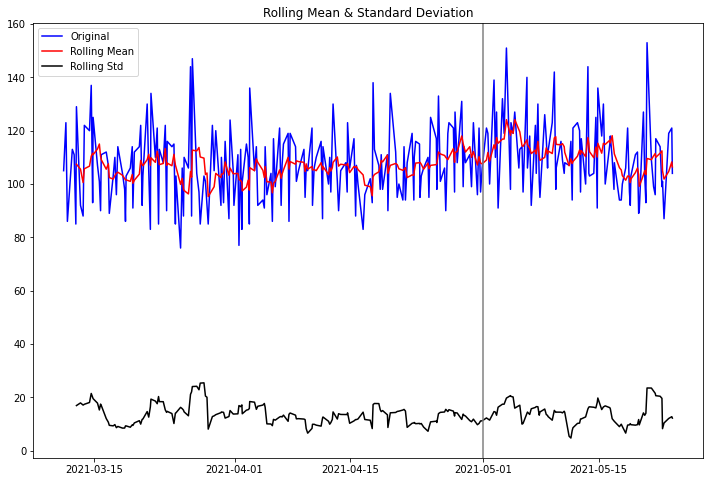

Results of Dickey-Fuller Test:
Test Statistic                  -2.444423
p-value                          0.129589
#Lags Used                      15.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


In [65]:
jlcap_test_stationarity(y)

Because the p-value is above .05 we cannot reject the null hypothesis that the time series is non-stationary.

In [67]:
statistic, p_value, n_lags, critical_values = kpss(y)
print('statistic:', statistic)
print('p_value:', p_value)
print('n_lags:', n_lags)
print('critical_values:', critical_values)

statistic: 0.9627808714956184
p_value: 0.01
n_lags: 5
critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Just out of curiosity I ran my time series through the kpss test as well. It agrees that the time series is not stationary.

### ACF and PACF

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


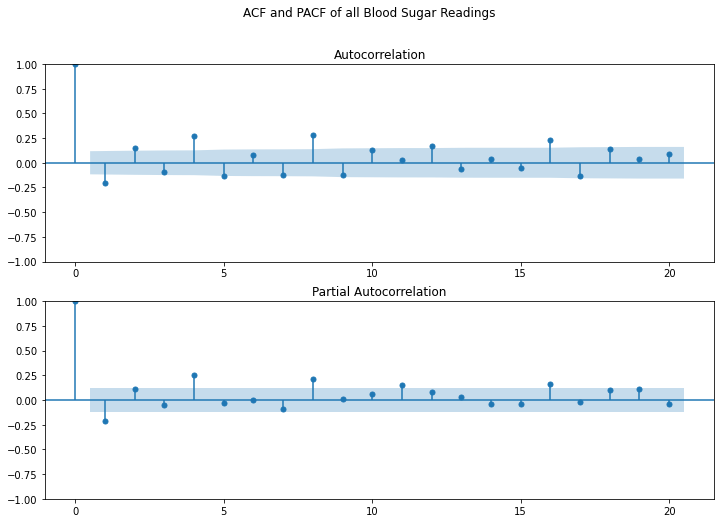

In [68]:
# Plot the ACF and PACF
fig, axes = plt.subplots(2,1)

plot_acf(y, lags=20, ax=axes[0])
plot_pacf(y, lags=20, ax=axes[1])

plt.suptitle('ACF and PACF of all Blood Sugar Readings')

plt.savefig('vis/full_acf-pacf.png', bbox_inches="tight")
plt.show()

**Notes**

The ACF shows small and patternless autocorrelations for all visualized lags. According to Duke University's guide on ARIMA models this indicates that the data does not need a higher order of differencing (Rule 2). This contradicts the results of the Dickey Fuller test.

**Let's diff to confirm**

In [71]:
y_diff = y.diff()
y_diff = y_diff.dropna()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


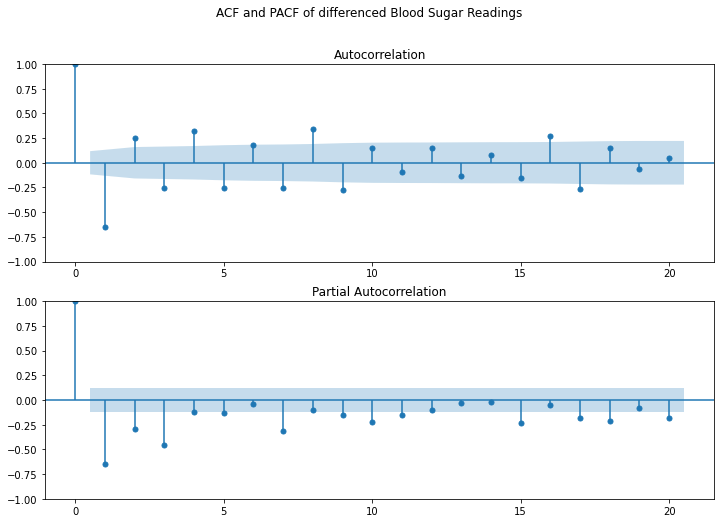

In [72]:
fig, axes = plt.subplots(2,1)

plot_acf(y_diff, lags=20, ax=axes[0])
plot_pacf(y_diff, lags=20, ax=axes[1])

plt.suptitle('ACF and PACF of differenced Blood Sugar Readings')

plt.savefig('vis/full_acf-pacf-diff.png', bbox_inches="tight")
plt.show()

<p>The lag-1 autocorrelation of the differenced timeseries confirms that the differencing is not needed (Rule 2).</p>

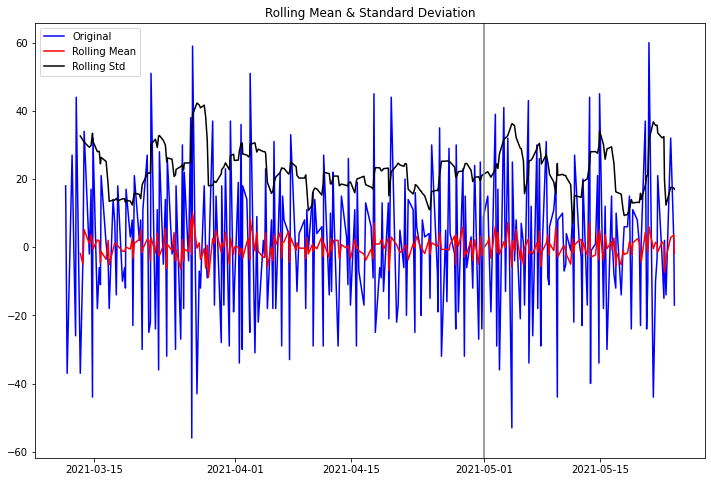

Results of Dickey-Fuller Test:
Test Statistic                -7.434151e+00
p-value                        6.247203e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.640000e+02
Critical Value (1%)           -3.455365e+00
Critical Value (5%)           -2.872551e+00
Critical Value (10%)          -2.572638e+00
dtype: float64


In [73]:
# Test the stationarity again using the differenced time series
jlcap_test_stationarity(y_diff)

Because the Dicky Fuller test and the ACF/PACF contradict each other in terms of identifying stationarity I'm going to have to rely on parameter optimization to find the best model order.

### Save Stationary Data

In [74]:
datapath = 'data'
save_file(y.reset_index(), 'data_full_pre-processed.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data/data_full_pre-processed.csv"
